In [14]:
import numpy
import matplotlib.pyplot as plt

from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling.amr.regnet import template_model_to_regnet_json
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
import json

## Define states for the model


In [15]:
susceptible = Concept(name="susceptible_population", identifiers={"ido": "0000514"})
infected = Concept(name="infected_population", identifiers={"ido": "0000511"})
recovered_broadly = Concept(name="recovered_broadly")
recovered_fully = Concept(name="recovered_fully")

## Define templates

In [16]:
# eta is the second recovery parameter governing the transition from broadly to fully recovered 

templates = [
    ControlledConversion(subject=susceptible,outcome=infected,controller=infected).with_mass_action_rate_law("beta"),
    NaturalConversion(subject=infected,outcome=recovered_broadly).with_mass_action_rate_law("gamma"),
    NaturalConversion(subject=recovered_broadly,outcome=recovered_fully).with_mass_action_rate_law("eta")
]

## Define Parameters and Initials

In [17]:
parameters = {
    "beta":Parameter(name="beta",value=.357),
    "gamma":Parameter(name="gamma",value=.143),
    "eta": Parameter(name="eta",value=.429)
}

In [18]:
# susceptible is initialized at .999
# infected is initialized at .001
# other states initialized at 0 
initials =  {
    "susceptible_0":Initial(concept=susceptible,expression=0.999),
    "infected_0":Initial(concept=infected,expression=0.1),
    "recovered_broadly_0": Initial(concept=recovered_broadly,expression=0.0),
    "recovered_fully_0": Initial(concept=recovered_fully,expression=0.0)
}

## Create the template model

In [19]:
tm = TemplateModel(templates=templates,
                   parameters=parameters,
                   initials=initials)

## Prepare the model for simulation


In [20]:
om = OdeModel(Model(tm), initialized=True)
om.kinetics

Matrix([
[                 -p[0, 0]*y[0, 0]*y[1, 0]],
[p[0, 0]*y[0, 0]*y[1, 0] - p[1, 0]*y[1, 0]],
[        p[1, 0]*y[1, 0] - p[2, 0]*y[2, 0]],
[                          p[2, 0]*y[2, 0]]])

In [21]:
# paper mentions that it takes 95 days before infectious levels fall below .001
ts = numpy.linspace(0, 100, 100)
res = simulate_ode_model(om, times=ts)

Text(0, 0.5, 'Percent of Population')

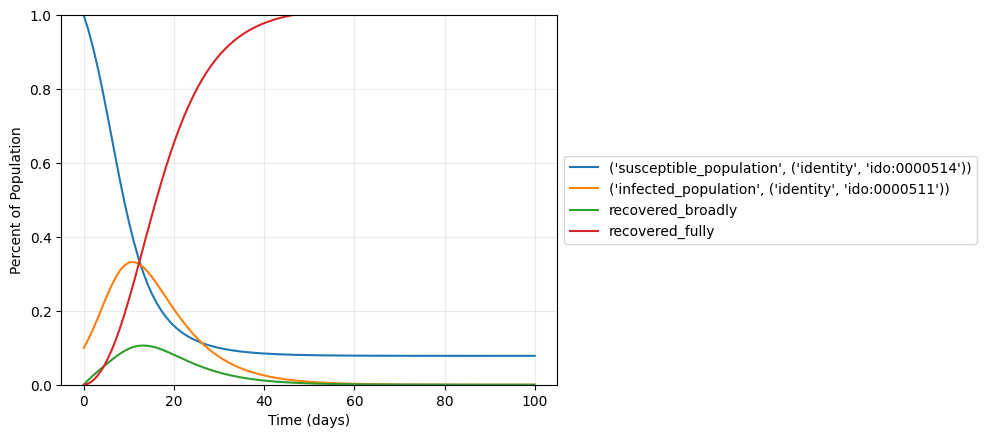

In [22]:
plt.plot(ts, res, label=om.vmap.keys())
plt.grid(alpha=0.25)
plt.ylim([0, 1])
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (days)')
plt.ylabel('Percent of Population')

## Export the model into different frameworks

In [23]:
frameworks = {'regnet': template_model_to_regnet_json, 'petrinet': template_model_to_petrinet_json}

for fkey, fun in frameworks.items():
    with open(f'scenario1_model_b_{fkey}.json', 'w') as fh:
        json.dump(fun(tm), fh, indent=1)